In [ ]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import scipy.io as io
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import json
import seaborn as sns
sns.set(style="white", context="talk")

Populating the interactive namespace from numpy and matplotlib


# From raw data to results and summary tables

In [ ]:
def entropy(labels, base=None):
    n_labels = len(labels)
    if n_labels <= 1:
        return 0
    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)
    if n_classes <= 1:
        return 0
    ent = 0.
    base = e if base is None else base
    for i in probs:
        ent -= i * np.math.log(i, base)
    return ent

In [ ]:
raw_data = pd.read_csv('Zooniverse_Data_2022_01_28.csv', engine='python') # all the data
raw_data_dic = raw_data['annotations'].to_dict()         # info on the responses
raw_ID = raw_data['subject_data'].to_dict()              # info on the images
user_id = raw_data['user_id'].to_dict()                  # info on the raters

In [ ]:
table = pd.DataFrame(columns=['rater','image_ID','image_name','Resp1','Resp2','Cat1','Cat2','Cat3'])

for image in np.arange(len(raw_data_dic.keys())):

    dic_on_image = json.loads(raw_ID.get(image))
    image_ID = list(dic_on_image.keys())[0]  # image ID
    dic_on_resp = json.loads(raw_data_dic.get(image))

    rater = user_id[image]

    try:
        image_name = dic_on_image.get(image_ID)['Filename']
    except:
        image_name = dic_on_image.get(image_ID)['image_name_1']

    image_resp1 = nan
    image_resp2 = nan
    image_cat1 = nan
    image_cat2 = nan
    image_cat3 = nan

    for task in np.arange(len(dic_on_resp)):

        if dic_on_resp[task].get('task') == 'T1':
            image_resp1 = dic_on_resp[task].get('value')   # first name
        if dic_on_resp[task].get('task') == 'T2':
            image_resp2 = dic_on_resp[task].get('value')   # second name

        if dic_on_resp[task].get('task') == 'T4':
            image_cat1 = dic_on_resp[task].get('value')   # image_cat1

        if dic_on_resp[task].get('task') == 'T3':
            image_cat2 = dic_on_resp[task].get('value')   # image_cat2
        if dic_on_resp[task].get('task') == 'T5':
            image_cat2 = dic_on_resp[task].get('value')   # image_cat2

        if dic_on_resp[task].get('task') == 'T6':
            image_cat3 = dic_on_resp[task].get('value')   # image_cat3
        if dic_on_resp[task].get('task') == 'T7':
            image_cat3 = dic_on_resp[task].get('value')   # image_cat3
        if dic_on_resp[task].get('task') == 'T8':
            image_cat3 = dic_on_resp[task].get('value')   # image_cat3
        if dic_on_resp[task].get('task') == 'T9':
            image_cat3 = dic_on_resp[task].get('value')   # image_cat3

    table.loc[image] = [rater,image_ID,image_name,image_resp1,image_resp2,image_cat1,image_cat2,image_cat3]

In [ ]:
table2 = pd.DataFrame(columns=['image_ID','image_name','howmany','Resp1','Resp2',
                               'Cat1','Cat2','Cat3',
                               'Cat1_agr','Cat2_agr','Cat3_agr',
                               'Comp_dem','Most_comm','Entropy'])

for image in np.arange(len(table['image_ID'].unique())):

    checking = table['image_ID'].unique()[image]
    howmany = len(table[table['image_ID']==checking])
    image_name = table[table['image_ID']==checking]['image_name'].unique()[0]

    Resp1 = table[table['image_ID']==checking]['Resp1'].str.lower().str.rstrip().value_counts(ascending=False)
    Resp2 = table[table['image_ID']==checking]['Resp2'].str.lower().str.rstrip().value_counts(ascending=False)

    for t,tt in enumerate(table[table['image_ID']==checking]['Cat1'][table[table['image_ID']==checking]['Cat1']=='animate and/or living'].index):
        table.loc[tt,'Cat1'] = 'animate / living'
    Cat1 = table[table['image_ID']==checking]['Cat1'].value_counts(ascending=False)

    for t,tt in enumerate(table[table['image_ID']==checking]['Cat1'][table[table['image_ID']==checking]['Cat1']=='inanimate and/or  nonliving'].index):
        table.loc[tt,'Cat1'] = 'inanimate / nonliving'
    Cat1 = table[table['image_ID']==checking]['Cat1'].value_counts(ascending=False)

    Cat2 = table[table['image_ID']==checking]['Cat2'].value_counts(ascending=False)
    Cat3 = table[table['image_ID']==checking]['Cat3'].value_counts(ascending=False)

    # % agreement on Cat1
    if Cat1[0]==howmany:
        agreement1 = 100
    else:
        agreement1 = (Cat1[0]/howmany)*100

    # % agreement on Cat2
    if Cat2[0]==howmany:
        agreement2 = 100
    else:
        agreement2 = (Cat2[0]/howmany)*100

    # % agreement on Cat3
    if len(Cat3) ==0:
        agreement3 = nan
    elif Cat3[0]==howmany:
        agreement3 = 100
    else:
        agreement3 = (Cat3[0]/howmany)*100

    # ratio between the percentage of subjects providing
    # the most common response and the second most common one
    if len(Resp1)>2:
        comp_dem = ((Resp1[0]/howmany)*100)/((Resp1[1]/howmany)*100)
    else:
        comp_dem = 0

    # percentage of subjects providing the most common response
    most_comm = (Resp1[0]/howmany)*100

    # Entropy/H-index:
    #ent = entropy(np.array(table[table['image_ID']==checking]['Resp1'].str.lower().str.rstrip()))
    s = pd.Series(np.array(table[table['image_ID']==checking]['Resp1'].str.lower().str.rstrip()))
    ent = entropy(s.dropna().values)

    table2.loc[image] = [checking,image_name,howmany,dict(Resp1),dict(Resp2),
                         dict(Cat1),dict(Cat2),dict(Cat3),
                         agreement1,agreement2,agreement3,
                        comp_dem,most_comm,ent]

# Basic Plots

In [ ]:
summary_data = pd.read_csv('Zooniverse_Results_Summary_2022_01_29.csv') # all the data

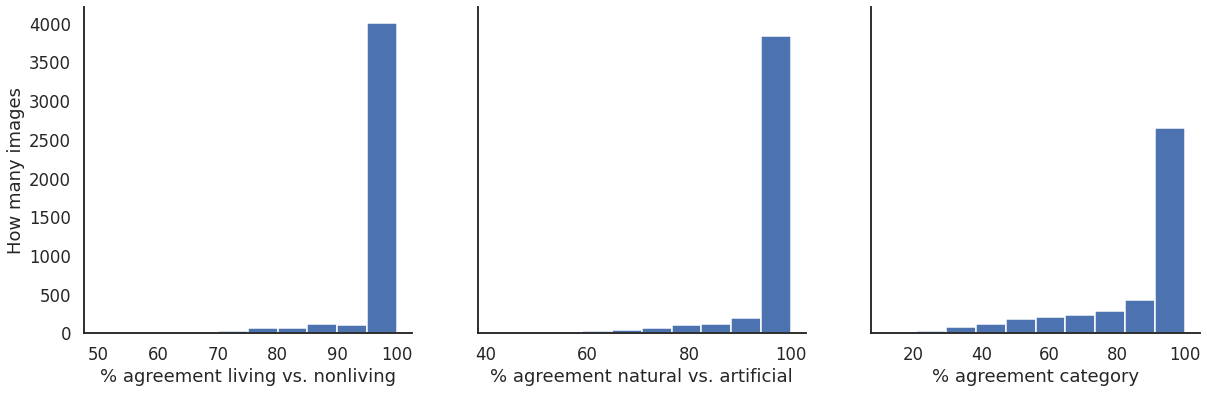

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

a = ax1.hist(summary_data['Cat1_agr'])
b = ax2.hist(summary_data['Cat2_agr'])
c = ax3.hist(summary_data['Cat3_agr'])

ax1.set_xlabel("% agreement living vs. nonliving")
ax2.set_xlabel("% agreement natural vs. artificial")
ax3.set_xlabel("% agreement category")

ax1.set_ylabel("How many images")

sns.despine(left=False, right=True, bottom=False, top=True)

plt.show()

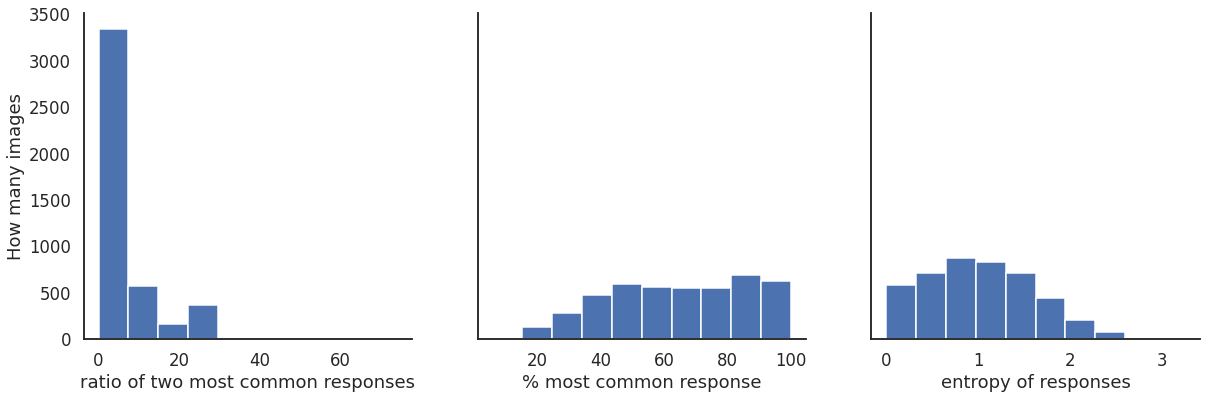

In [ ]:
f, (ax4,ax5,ax6) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

d = ax4.hist(summary_data['Comp_dem'])
e = ax5.hist(summary_data['Most_comm'])
f = ax6.hist(summary_data['Entropy'])

ax4.set_xlabel("ratio of two most common responses")
ax5.set_xlabel("% most common response")
ax6.set_xlabel("entropy of responses")

ax4.set_ylabel("How many images")

sns.despine(left=False, right=True, bottom=False, top=True)

plt.show()

# Check dropped ones and hard ones

In [ ]:
dropped = summary_data[summary_data.howmany_saw-summary_data.howmany_name>1]
dropped.describe()

,image_ID,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy
count,3.560000e+03,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3376.000000,3560.000000,3560.000000,3560.000000
mean,7.204576e+07,30.396067,25.473596,25.473596,25.473596,25.473596,97.975423,96.863358,86.295433,5.805655,63.096371,1.081538
std,2.498336e+05,1.743897,3.408480,3.408480,3.408480,3.408480,6.387546,8.414567,19.040322,6.965272,21.847147,0.581860
min,6.150984e+07,30.000000,3.000000,3.000000,3.000000,3.000000,52.631579,42.307692,12.000000,0.000000,5.882353,0.000000
25%,7.205055e+07,30.000000,24.000000,24.000000,24.000000,24.000000,100.000000,100.000000,78.260870,1.400000,46.073718,0.642599
50%,7.205169e+07,30.000000,26.000000,26.000000,26.000000,26.000000,100.000000,100.000000,96.000000,3.000000,64.000000,1.059112
75%,7.205278e+07,30.000000,27.000000,27.000000,27.000000,27.000000,100.000000,100.000000,100.000000,7.000000,81.818182,1.486897
max,7.205388e+07,78.000000,76.000000,76.000000,76.000000,76.000000,100.000000,100.000000,100.000000,31.000000,100.000000,2.833213


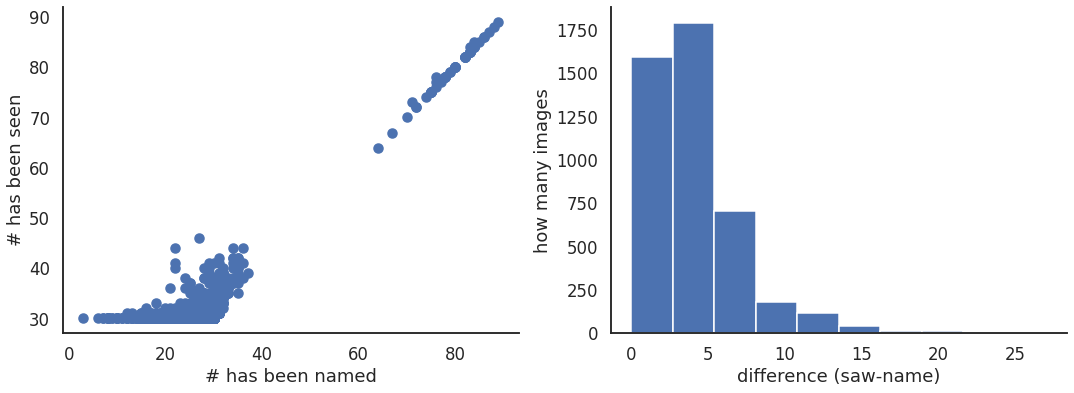

In [ ]:
f, (ax4,ax5) = plt.subplots(1, 2, figsize=(18, 6), sharey=False, sharex=False)

d = ax4.scatter(summary_data['howmany_name'],summary_data['howmany_saw'])
e = ax5.hist(summary_data['howmany_saw']-summary_data['howmany_name'])

ax4.set_xlabel("# has been named")
ax4.set_ylabel("# has been seen")

ax5.set_xlabel("difference (saw-name)")
ax5.set_ylabel("how many images")

sns.despine(left=False, right=True, bottom=False, top=True)

plt.show()

In [ ]:
few_answers = summary_data[summary_data['howmany_name']<10]
many_answers = summary_data[summary_data['howmany_name']>20]

In [ ]:
few_answers[few_answers['Most_comm']<20]

,image_ID,image_name,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Resp1,Resp2,Cat1,Cat2,Cat3,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy
761,72053183,punch07-compressed.jpg,30,7,7,7,7,"{'holepunch': 1, 'thingy': 1, 'three-hole punc...","{'': 3, '3-hole punch': 1, 'sensor': 1, 'paper...",{'inanimate / nonliving': 7},{'artificial / manmade': 7},"{'tool, musical instrument, or medical device'...",100.0,100.0,71.428571,1.0,14.285714,1.945910
3387,72051310,meter02-compressed.jpg,30,8,8,8,8,"{'clock': 1, 'blood sugar check': 1, 'pedomete...","{'no': 2, '': 2, 'watch': 1, 'insulin check': ...",{'inanimate / nonliving': 8},{'artificial / manmade': 8},"{'tool, musical instrument, or medical device'...",100.0,100.0,62.500000,1.0,12.500000,2.079442


In [ ]:
summary_data[summary_data['image_ID']==72053753]

,image_ID,image_name,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Resp1,Resp2,Cat1,Cat2,Cat3,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy
252,72053753,face_beaver06-compressed.jpg,30,19,19,19,19,"{'marmot': 4, 'gopher': 3, 'rodent': 3, 'beave...","{'': 11, 'no': 3, 'groundhog': 2, 'rodent': 1,...",{'animate / living': 19},"{'Animal': 18, 'Human': 1}","{'mammal': 17, 'aquatic mammal': 1}",100.0,94.736842,94.444444,1.333333,21.052632,2.059229


In [ ]:
many_answers[many_answers['Most_comm']<13]

,image_ID,image_name,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Resp1,Resp2,Cat1,Cat2,Cat3,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy
681,72053794,controller03-compressed.jpg,30,25,25,25,25,"{'game controllers': 3, 'video game controller...","{'': 12, 'controllers': 2, 'hand controller': ...",{'inanimate / nonliving': 25},{'artificial / manmade': 25},"{'sport, game, or leisure item': 22, 'furnitur...",100.0,100.0,88.0,1.5,12.000000,2.754332
3768,72052633,miniature_golf01-compressed.jpg,30,24,24,24,24,"{'crazy golf course': 2, 'mini golf': 2, 'mini...","{'': 7, 'no': 2, 'putt-putt': 2, 'mini golf': ...",{'inanimate / nonliving': 24},{'artificial / manmade': 24},"{'sport, game, or leisure item': 24}",100.0,100.0,100.0,1.0,8.333333,2.773718


In [ ]:
many_answers[many_answers['Most_comm']<30]

,image_ID,image_name,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Resp1,Resp2,Cat1,Cat2,Cat3,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy
11,61509867,RV01.jpg,67,67,67,67,67,"{'rv': 19, 'camper van': 7, 'bus': 7, 'motor h...","{'rv': 11, 'camper': 7, 'recreational vehicle'...",{'inanimate / nonliving': 67},"{'artificial': 66, 'artificial / manmade': 1}","{'vehicle': 66, 'vehicle or means of transport...",100.000000,98.507463,98.507463,2.714286,28.358209,2.433807
26,61509873,sphygmomanometer01.jpg,75,75,75,75,75,"{'sphygmomanometer': 12, 'gauge': 9, 'blood pr...","{'': 14, 'dial': 6, 'sphygmomanometer': 5, 'bl...",{'inanimate / nonliving': 75},{'artificial': 75},"{'tool or instrument': 74, 'medical instrument...",100.000000,100.000000,98.666667,1.333333,16.000000,3.249828
32,61509848,elder_female_face00.jpg,78,78,78,78,78,"{'woman': 15, 'old lady': 10, 'grandma': 6, 'f...","{'': 8, 'woman': 7, 'human': 5, 'grandma': 4, ...","{'animate / living': 76, 'inanimate / nonlivin...","{'Human': 76, 'artificial': 2}","{'clothing or jewelry': 1, 'medical aid': 1}",97.435897,97.435897,50.000000,1.500000,19.230769,2.789786
42,61509845,checkers01.jpg,77,77,77,77,77,"{'checkers': 23, 'checker board': 9, 'draughts...","{'': 12, 'checkers': 12, 'game': 10, 'board ga...",{'inanimate / nonliving': 77},"{'artificial': 73, 'natural': 4}","{'sport or game': 72, 'plants': 4, 'game': 1}",100.000000,94.805195,93.506494,2.555556,29.870130,2.641539
58,72050392,rosary05-compressed.jpg,30,21,21,21,21,"{'rosary': 6, 'rosary beads': 4, 'rosaries': 4...","{'': 11, 'beads': 2, 'rosary': 1, 'stones': 1,...",{'inanimate / nonliving': 21},{'artificial / manmade': 21},"{'clothing, jewelry or accessory': 18, 'religi...",100.000000,100.000000,85.714286,1.500000,28.571429,2.004479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,72053010,binder06-compressed.jpg,31,27,27,27,27,"{'folder': 7, 'binder': 5, 'pocket': 3, 'noteb...","{'': 7, 'binder': 7, 'jeans': 3, 'folder': 2, ...",{'inanimate / nonliving': 27},{'artificial / manmade': 27},"{'clothing, jewelry or accessory': 9, 'tool, m...",100.000000,100.000000,33.333333,1.400000,25.925926,2.197817
4401,72053872,memo03-compressed.jpg,37,31,31,31,31,"{'post it notes': 7, 'sticky notes': 5, 'stick...","{'': 12, 'post it note': 2, 'notes': 1, 'stick...",{'inanimate / nonliving': 31},{'artificial / manmade': 31},"{'tool, musical instrument, or medical device'...",100.000000,100.000000,29.032258,1.400000,22.580645,2.377248
4422,72052049,rollerblade02-compressed.jpg,30,27,27,27,27,"{'rollerblades': 8, 'roller blades': 7, 'inlin...","{'': 8, 'skates': 4, 'inline skates': 3, 'roll...",{'inanimate / nonliving': 27},{'artificial / manmade': 27},"{'sport, game, or leisure item': 25, 'vehicle ...",100.000000,100.000000,92.592593,1.142857,29.629630,1.969834
4425,72050141,earphone03-compressed.jpg,31,27,27,27,27,"{'earphones': 8, 'earbuds': 7, 'headphones': 5...","{'': 10, 'headphones': 8, 'earbuds': 3, 'earph...",{'inanimate / nonliving': 27},{'artificial / manmade': 27},"{'tool, musical instrument, or medical device'...",100.000000,100.000000,44.444444,1.142857,29.629630,1.671790


# Else

In [ ]:
summary_data['dropped'] = summary_data.howmany_saw-summary_data.howmany_name

In [ ]:
summary_data

,image_ID,image_name,howmany_saw,howmany_name,howmany_cat1,howmany_cat2,howmany_cat2.1,Resp1,Resp2,Cat1,Cat2,Cat3,Cat1_agr,Cat2_agr,Cat3_agr,Comp_dem,Most_comm,Entropy,dropped
0,61509833,body_falcon01.jpg,84,84,84,84,84,"{'hawk': 28, 'bird': 27, 'eagle': 9, 'falcon':...","{'bird of prey': 20, '': 12, 'hawk': 12, 'bird...",{'animate / living': 84},{'Animal': 84},{'bird': 84},100.000000,100.000000,100.000000,1.037037,33.333333,1.707354,0
1,61509865,punch01.jpg,86,86,86,86,86,"{'hole punch': 39, 'hole puncher': 13, 'punch'...","{'': 32, 'hole punch': 6, 'hole puncher': 6, '...",{'inanimate / nonliving': 86},"{'artificial': 85, 'artificial / manmade': 1}","{'tool or instrument': 84, 'clothing or jewelr...",100.000000,98.837209,97.674419,3.000000,45.348837,2.231874,0
2,61509837,body_marauder01.jpg,85,85,85,85,85,"{'otter': 71, 'beaver': 2, 'ferret': 2, 'ocelo...","{'': 38, 'no': 10, 'river otter': 8, 'mammal':...",{'animate / living': 85},{'Animal': 85},"{'aquatic mammal': 56, 'mammal': 29}",100.000000,100.000000,65.882353,35.500000,83.529412,0.849441,0
3,61509864,pregnancy_test01.jpg,87,87,87,87,87,"{'pregnancy test': 52, 'pregnancy tester': 8, ...","{'': 37, 'test': 6, 'no': 5, 'positive pregnan...",{'inanimate / nonliving': 87},"{'artificial': 86, 'artificial / manmade': 1}","{'tool or instrument': 75, 'medical device': 1...",100.000000,98.850575,86.206897,6.500000,59.770115,1.837266,0
4,61509847,corkscrew01.jpg,82,82,82,82,82,"{'corkscrew': 40, 'cork screw': 10, 'bottle op...","{'': 25, 'bottle opener': 16, 'wine opener': 1...","{'inanimate / nonliving': 80, 'animate / livin...","{'artificial': 79, 'Else': 2, 'artificial / ma...","{'tool or instrument': 79, 'tool, musical inst...",97.560976,96.341463,98.750000,4.000000,48.780488,1.909863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463,72053490,dice07-compressed.jpg,30,28,28,28,28,"{'dice': 27, 'dices': 1}","{'': 22, 'bones': 2, 'die': 2, 'no': 1, 'cubes...",{'inanimate / nonliving': 28},{'artificial / manmade': 28},"{'sport, game, or leisure item': 27, 'furnitur...",100.000000,100.000000,96.428571,0.000000,96.428571,0.154076,2
4464,72051702,bed07-compressed.jpg,32,31,31,31,31,{'bed': 31},"{'': 25, 'double bed': 2, 'bedstead': 1, 'sing...",{'inanimate / nonliving': 31},{'artificial / manmade': 31},"{'furniture, appliance, or decoration': 31}",100.000000,100.000000,100.000000,0.000000,100.000000,0.000000,1
4465,72051559,body_heron04-compressed.jpg,30,22,22,22,22,"{'heron': 18, 'blue heron': 1, 'grey heron': 1...","{'': 8, 'bird': 5, 'crane': 2, 'no': 1, 'wadin...",{'animate / living': 22},{'Animal': 22},{'bird': 22},100.000000,100.000000,100.000000,18.000000,81.818182,0.726193,8
4466,72049649,speaker09-compressed.jpg,30,23,23,23,23,"{'speaker': 19, 'computer speaker': 1, 'blue w...","{'': 13, 'sound system': 2, 'wireless speaker'...",{'inanimate / nonliving': 23},{'artificial / manmade': 23},"{'tool, musical instrument, or medical device'...",100.000000,100.000000,56.521739,19.000000,82.608696,0.703132,7


In [ ]:
summary_data.iloc[4465].Resp1

"{'heron': 18, 'blue heron': 1, 'grey heron': 1, 'great blue heron': 1, 'bird': 1}"